# PHASE 2: Quality Control & NDVI Filtering

**Projektphase:** Feature Extraction & Quality Control  
**Datum:** Januar 2026  
**Autor:** Silas Pignotti

---

## Ziel

Spektrale Qualitätskontrolle: Entferne Bäume mit Cloud-Artefakten oder fehlender Vegetationssignatur.

## Input

- `data/features/trees_with_features_Berlin.gpkg` (aus Phase 1)
- `data/features/trees_with_features_Hamburg.gpkg`
- `data/features/trees_with_features_Rostock.gpkg`

**Feature-Struktur:**
- Baum-Attribute: `tree_id`, `city`, `genus_latin`, `species_latin`, `height_m`, `geometry`
- CHM-Features (3): `CHM_mean`, `CHM_max`, `CHM_std`
- S2-Features (180): `B02_01` ... `B02_12`, `B03_01` ... `RTVIcore_12`
- **Total:** 184 Features + Metadaten

## Filterstrategien

1. **NDVI-Filter:** NDVI_max ≥ 0.3 (Vegetationssignatur)
2. **Spektrale Outlier:** B04_max < 5000, B08_max < 8000 (Cloud-Artefakte)
3. **Null-Filter:** Entferne Bäume mit allen Spektralwerten = 0

## Output

- `data/features/trees_with_features_clean_{city}.gpkg`
- `data/features/reports/qc_report.csv`
- `data/features/reports/qc_summary.txt`
- Visualisierungen: NDVI-Verteilung, Filter-Cascade

---

## 1. Setup & Configuration

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, Tuple, List
import warnings
warnings.filterwarnings('ignore')

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


### File Paths Configuration

**⚠️ ANPASSEN:** Ändere diese Pfade entsprechend deiner Google Drive Struktur

In [2]:
# Mount Google Drive (if using Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted")
except:
    print("ℹ Not running in Colab - skipping drive mount")

Mounted at /content/drive
✓ Google Drive mounted


In [3]:
# Base paths - HIER ANPASSEN
BASE_PATH = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")
FEATURES_DIR = BASE_PATH / "data" / "features"
REPORTS_DIR = FEATURES_DIR / "reports"

# Create reports directory if it doesn't exist
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Cities to process
CITIES = ["Berlin", "Hamburg", "Rostock"]

# Filter thresholds
NDVI_MIN = 0.3        # Minimum NDVI for vegetation
B04_MAX = 5000        # Maximum Red reflectance (cloud artifacts)
B08_MAX = 8000        # Maximum NIR reflectance (cloud artifacts)

print(f"✓ Configuration loaded")
print(f"  Base path: {BASE_PATH}")
print(f"  Features dir: {FEATURES_DIR}")
print(f"  Reports dir: {REPORTS_DIR}")
print(f"  Cities: {', '.join(CITIES)}")

✓ Configuration loaded
  Base path: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit
  Features dir: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features
  Reports dir: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports
  Cities: Berlin, Hamburg, Rostock


---

## 2. Helper Functions

In [4]:
def load_tree_features(city: str) -> gpd.GeoDataFrame:
    """
    Load tree features from Phase 1 output.

    Args:
        city: City name (Berlin, Hamburg, Rostock)

    Returns:
        GeoDataFrame with tree features
    """
    filepath = FEATURES_DIR / f"trees_with_features_{city}.gpkg"

    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")

    gdf = gpd.read_file(filepath)
    print(f"✓ Loaded {len(gdf):,} trees from {city}")

    return gdf


def calculate_ndvi_max(gdf: gpd.GeoDataFrame) -> np.ndarray:
    """
    Calculate maximum NDVI across all months.

    NDVI = (NIR - Red) / (NIR + Red)

    Args:
        gdf: GeoDataFrame with monthly spectral bands

    Returns:
        Array with NDVI_max values
    """
    ndvi_monthly = []

    for month in range(1, 13):
        b04_col = f"B04_{month:02d}"  # Red
        b08_col = f"B08_{month:02d}"  # NIR

        if b04_col not in gdf.columns or b08_col not in gdf.columns:
            print(f"⚠ Warning: Missing bands for month {month}")
            continue

        b04 = gdf[b04_col].values
        b08 = gdf[b08_col].values

        # Calculate NDVI with epsilon to avoid division by zero
        eps = 1e-6
        ndvi = (b08 - b04) / (b08 + b04 + eps)
        ndvi_monthly.append(ndvi)

    # Stack and compute max across months
    ndvi_stack = np.column_stack(ndvi_monthly)
    ndvi_max = np.nanmax(ndvi_stack, axis=1)

    return ndvi_max


def calculate_spectral_max(gdf: gpd.GeoDataFrame, band: str) -> np.ndarray:
    """
    Calculate maximum reflectance across all months for a given band.

    Args:
        gdf: GeoDataFrame with monthly spectral bands
        band: Band name (e.g., 'B04', 'B08')

    Returns:
        Array with max values
    """
    band_monthly = []

    for month in range(1, 13):
        col = f"{band}_{month:02d}"
        if col in gdf.columns:
            band_monthly.append(gdf[col].values)

    band_stack = np.column_stack(band_monthly)
    band_max = np.nanmax(band_stack, axis=1)

    return band_max


def calculate_spectral_sum(gdf: gpd.GeoDataFrame) -> np.ndarray:
    """
    Calculate sum of all spectral bands across all months.
    Used to detect 'all-zero' pixels.

    Args:
        gdf: GeoDataFrame with monthly spectral bands

    Returns:
        Array with sum values
    """
    bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
    total_sum = np.zeros(len(gdf))

    for band in bands:
        for month in range(1, 13):
            col = f"{band}_{month:02d}"
            if col in gdf.columns:
                total_sum += gdf[col].fillna(0).values

    return total_sum


print("✓ Helper functions defined")

✓ Helper functions defined


---

## 3. Quality Control Filters

In [5]:
def apply_qc_filters(gdf: gpd.GeoDataFrame, city: str) -> Tuple[gpd.GeoDataFrame, Dict]:
    """
    Apply all quality control filters sequentially.

    Filters:
    1. NDVI-Filter: NDVI_max >= 0.3
    2. Spectral Outlier: B04_max < 5000, B08_max < 8000
    3. Null-Filter: Spectral sum > 0

    Args:
        gdf: Input GeoDataFrame
        city: City name for reporting

    Returns:
        Filtered GeoDataFrame and statistics dictionary
    """
    original_count = len(gdf)
    stats = {'city': city, 'original_count': original_count}

    print(f"\n{'='*60}")
    print(f"Processing {city}")
    print(f"{'='*60}")
    print(f"Original trees: {original_count:,}")

    # ========================================
    # Filter 1: NDVI Filter
    # ========================================
    print(f"\n[1/3] NDVI Filter (threshold: {NDVI_MIN})...")
    ndvi_max = calculate_ndvi_max(gdf)
    gdf['NDVI_max'] = ndvi_max  # Store for later analysis

    mask_ndvi = ndvi_max >= NDVI_MIN
    gdf_after_ndvi = gdf[mask_ndvi].copy()

    removed_ndvi = original_count - len(gdf_after_ndvi)
    stats['after_ndvi'] = len(gdf_after_ndvi)
    stats['removed_ndvi'] = removed_ndvi

    print(f"  Removed: {removed_ndvi:,} ({100 * removed_ndvi / original_count:.2f}%)")
    print(f"  Remaining: {len(gdf_after_ndvi):,} ({100 * len(gdf_after_ndvi) / original_count:.2f}%)")

    # ========================================
    # Filter 2: Spectral Outlier Filter
    # ========================================
    print(f"\n[2/3] Spectral Outlier Filter (B04 < {B04_MAX}, B08 < {B08_MAX})...")
    b04_max = calculate_spectral_max(gdf_after_ndvi, 'B04')
    b08_max = calculate_spectral_max(gdf_after_ndvi, 'B08')

    gdf_after_ndvi['B04_max'] = b04_max  # Store for analysis
    gdf_after_ndvi['B08_max'] = b08_max

    mask_spectral = (b04_max < B04_MAX) & (b08_max < B08_MAX)
    gdf_after_spectral = gdf_after_ndvi[mask_spectral].copy()

    removed_spectral = len(gdf_after_ndvi) - len(gdf_after_spectral)
    stats['after_spectral'] = len(gdf_after_spectral)
    stats['removed_spectral'] = removed_spectral

    print(f"  Removed: {removed_spectral:,} ({100 * removed_spectral / original_count:.2f}%)")
    print(f"  Remaining: {len(gdf_after_spectral):,} ({100 * len(gdf_after_spectral) / original_count:.2f}%)")

    # ========================================
    # Filter 3: Null Filter
    # ========================================
    print(f"\n[3/3] Null Filter (spectral sum > 0)...")
    spectral_sum = calculate_spectral_sum(gdf_after_spectral)
    gdf_after_spectral['spectral_sum'] = spectral_sum

    mask_zero = spectral_sum > 0
    gdf_clean = gdf_after_spectral[mask_zero].copy()

    removed_zero = len(gdf_after_spectral) - len(gdf_clean)
    stats['after_zero'] = len(gdf_clean)
    stats['removed_zero'] = removed_zero

    print(f"  Removed: {removed_zero:,} ({100 * removed_zero / original_count:.2f}%)")
    print(f"  Remaining: {len(gdf_clean):,} ({100 * len(gdf_clean) / original_count:.2f}%)")

    # ========================================
    # Final Statistics
    # ========================================
    stats['final_count'] = len(gdf_clean)
    stats['total_removed'] = original_count - len(gdf_clean)
    stats['retention_pct'] = 100 * len(gdf_clean) / original_count

    print(f"\n{'='*60}")
    print(f"FINAL RESULT for {city}:")
    print(f"  Original:  {original_count:,}")
    print(f"  Final:     {len(gdf_clean):,}")
    print(f"  Removed:   {stats['total_removed']:,} ({100 - stats['retention_pct']:.2f}%)")
    print(f"  Retained:  {stats['retention_pct']:.2f}%")
    print(f"{'='*60}\n")

    # Remove temporary columns used for filtering
    cols_to_drop = ['NDVI_max', 'B04_max', 'B08_max', 'spectral_sum']
    gdf_clean = gdf_clean.drop(columns=[c for c in cols_to_drop if c in gdf_clean.columns])

    return gdf_clean, stats


print("✓ Quality control filter function defined")

✓ Quality control filter function defined


---

## 4. Visualization Functions

In [6]:
def plot_ndvi_distribution(gdf_before: gpd.GeoDataFrame,
                          gdf_after: gpd.GeoDataFrame,
                          city: str,
                          save_path: Path = None):
    """
    Plot NDVI distribution before and after filtering.

    Args:
        gdf_before: GeoDataFrame before filtering (with NDVI_max)
        gdf_after: GeoDataFrame after filtering
        city: City name
        save_path: Path to save figure (optional)
    """
    # Calculate NDVI for before dataset
    ndvi_before = calculate_ndvi_max(gdf_before)
    ndvi_after = calculate_ndvi_max(gdf_after)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Before filtering
    axes[0].hist(ndvi_before, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].axvline(NDVI_MIN, color='red', linestyle='--', linewidth=2, label=f'Threshold: {NDVI_MIN}')
    axes[0].set_xlabel('NDVI_max')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'{city} - NDVI Distribution BEFORE Filtering\n(n={len(gdf_before):,})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # After filtering
    axes[1].hist(ndvi_after, bins=100, alpha=0.7, color='forestgreen', edgecolor='black')
    axes[1].axvline(NDVI_MIN, color='red', linestyle='--', linewidth=2, label=f'Threshold: {NDVI_MIN}')
    axes[1].set_xlabel('NDVI_max')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{city} - NDVI Distribution AFTER Filtering\n(n={len(gdf_after):,})')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {save_path}")

    plt.show()


def plot_filter_cascade(stats: Dict, save_path: Path = None):
    """
    Plot cascade diagram showing tree count after each filter.

    Args:
        stats: Statistics dictionary from apply_qc_filters
        save_path: Path to save figure (optional)
    """
    city = stats['city']

    stages = ['Original', 'After NDVI', 'After Spectral', 'After Null', 'Final']
    counts = [
        stats['original_count'],
        stats['after_ndvi'],
        stats['after_spectral'],
        stats['after_zero'],
        stats['final_count']
    ]

    colors = ['steelblue', 'orange', 'gold', 'lightcoral', 'forestgreen']

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(stages, counts, color=colors, edgecolor='black', linewidth=1.5)

    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_ylabel('Number of Trees', fontsize=12)
    ax.set_title(f'{city} - Filter Cascade\nRetention Rate: {stats["retention_pct"]:.2f}%',
                fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {save_path}")

    plt.show()


print("✓ Visualization functions defined")

✓ Visualization functions defined


---

## 5. Main Processing Pipeline


############################################################
# PROCESSING: Berlin
############################################################
✓ Loaded 190,469 trees from Berlin

Processing Berlin
Original trees: 190,469

[1/3] NDVI Filter (threshold: 0.3)...
  Removed: 8,672 (4.55%)
  Remaining: 181,797 (95.45%)

[2/3] Spectral Outlier Filter (B04 < 5000, B08 < 8000)...
  Removed: 3,514 (1.84%)
  Remaining: 178,283 (93.60%)

[3/3] Null Filter (spectral sum > 0)...
  Removed: 0 (0.00%)
  Remaining: 178,283 (93.60%)

FINAL RESULT for Berlin:
  Original:  190,469
  Final:     178,283
  Removed:   12,186 (6.40%)
  Retained:  93.60%

✓ Saved cleaned data: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/trees_with_features_clean_Berlin.gpkg

Generating visualizations for Berlin...
  ✓ Saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/ndvi_distribution_Berlin.png


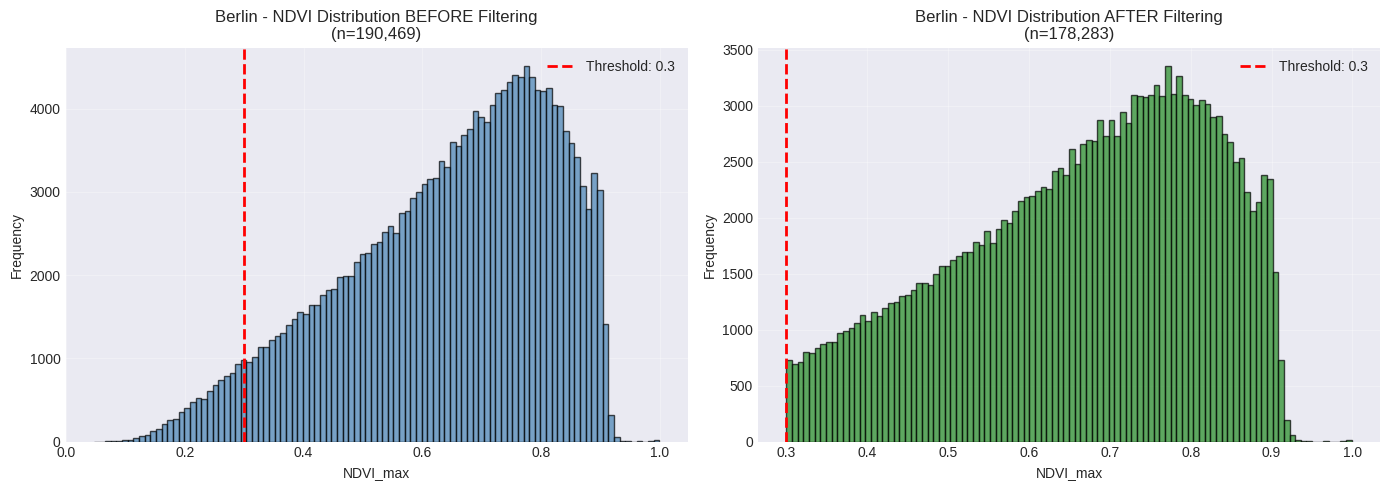

  ✓ Saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/filter_cascade_Berlin.png


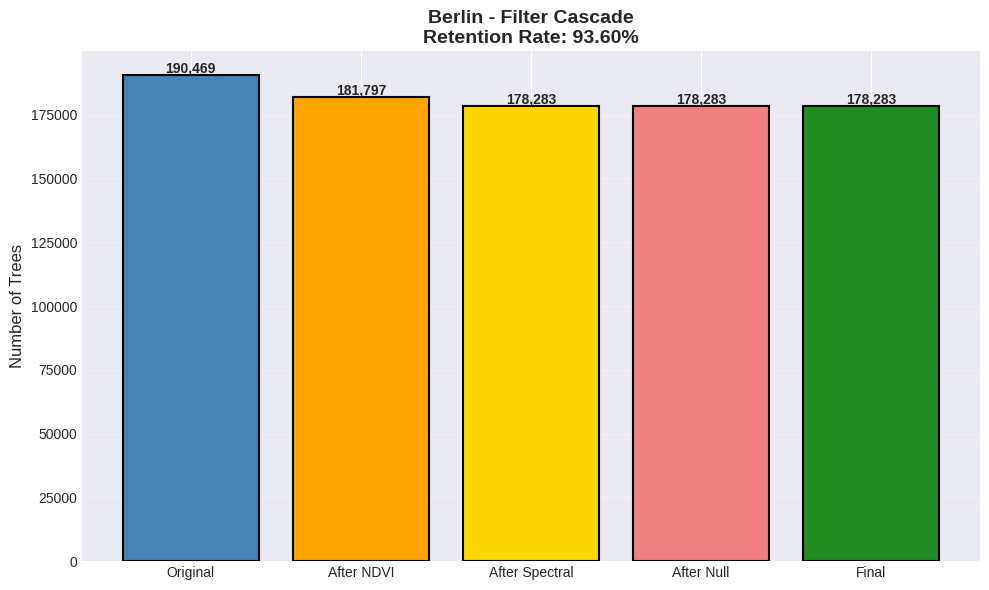


############################################################
# PROCESSING: Hamburg
############################################################
✓ Loaded 48,519 trees from Hamburg

Processing Hamburg
Original trees: 48,519

[1/3] NDVI Filter (threshold: 0.3)...
  Removed: 1,223 (2.52%)
  Remaining: 47,296 (97.48%)

[2/3] Spectral Outlier Filter (B04 < 5000, B08 < 8000)...
  Removed: 1,117 (2.30%)
  Remaining: 46,179 (95.18%)

[3/3] Null Filter (spectral sum > 0)...
  Removed: 0 (0.00%)
  Remaining: 46,179 (95.18%)

FINAL RESULT for Hamburg:
  Original:  48,519
  Final:     46,179
  Removed:   2,340 (4.82%)
  Retained:  95.18%

✓ Saved cleaned data: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/trees_with_features_clean_Hamburg.gpkg

Generating visualizations for Hamburg...
  ✓ Saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/ndvi_distribution_Hamburg.png


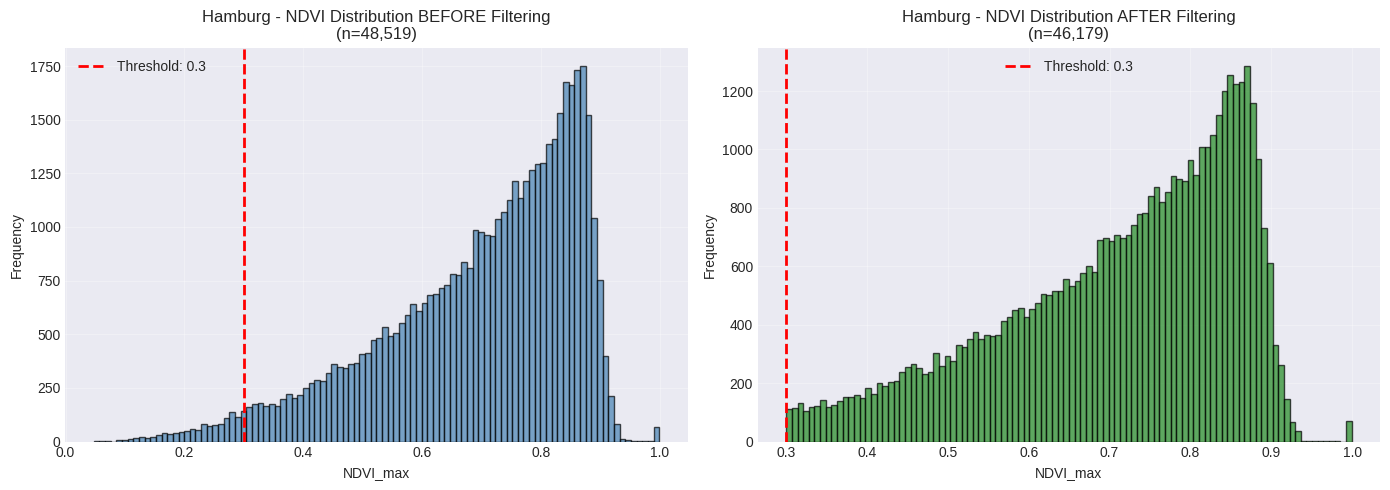

  ✓ Saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/filter_cascade_Hamburg.png


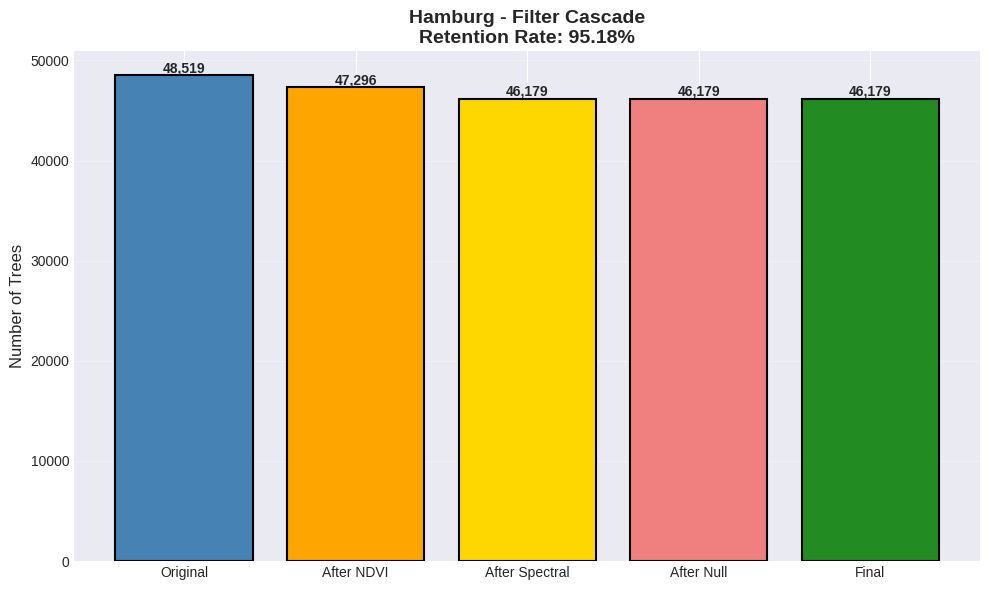


############################################################
# PROCESSING: Rostock
############################################################
✓ Loaded 16,691 trees from Rostock

Processing Rostock
Original trees: 16,691

[1/3] NDVI Filter (threshold: 0.3)...
  Removed: 371 (2.22%)
  Remaining: 16,320 (97.78%)

[2/3] Spectral Outlier Filter (B04 < 5000, B08 < 8000)...
  Removed: 180 (1.08%)
  Remaining: 16,140 (96.70%)

[3/3] Null Filter (spectral sum > 0)...
  Removed: 0 (0.00%)
  Remaining: 16,140 (96.70%)

FINAL RESULT for Rostock:
  Original:  16,691
  Final:     16,140
  Removed:   551 (3.30%)
  Retained:  96.70%

✓ Saved cleaned data: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/trees_with_features_clean_Rostock.gpkg

Generating visualizations for Rostock...
  ✓ Saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/ndvi_distribution_Rostock.png


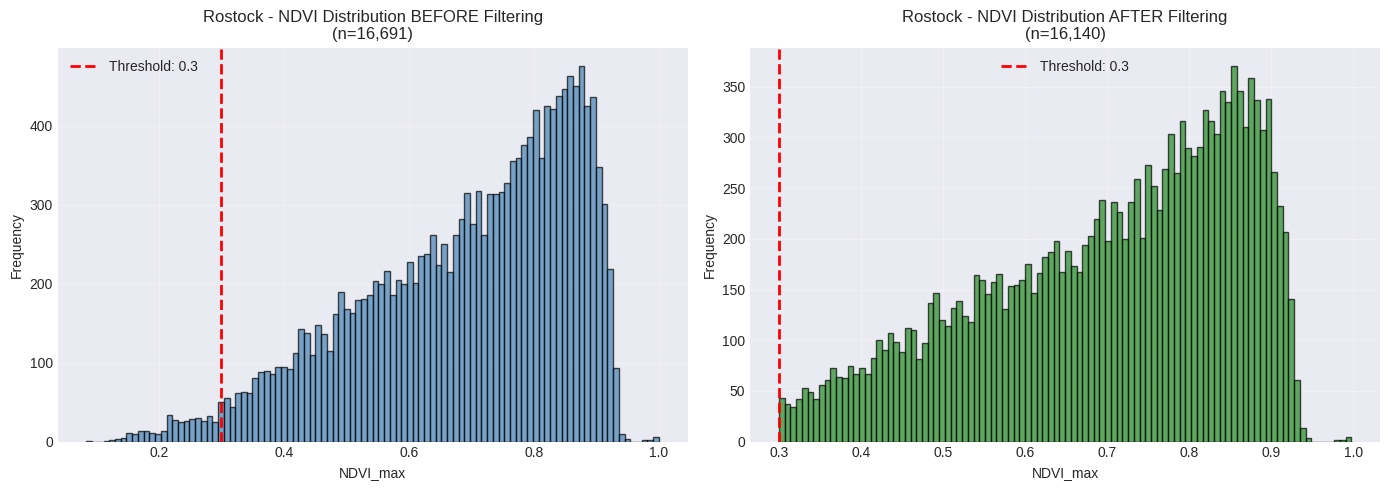

  ✓ Saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/filter_cascade_Rostock.png


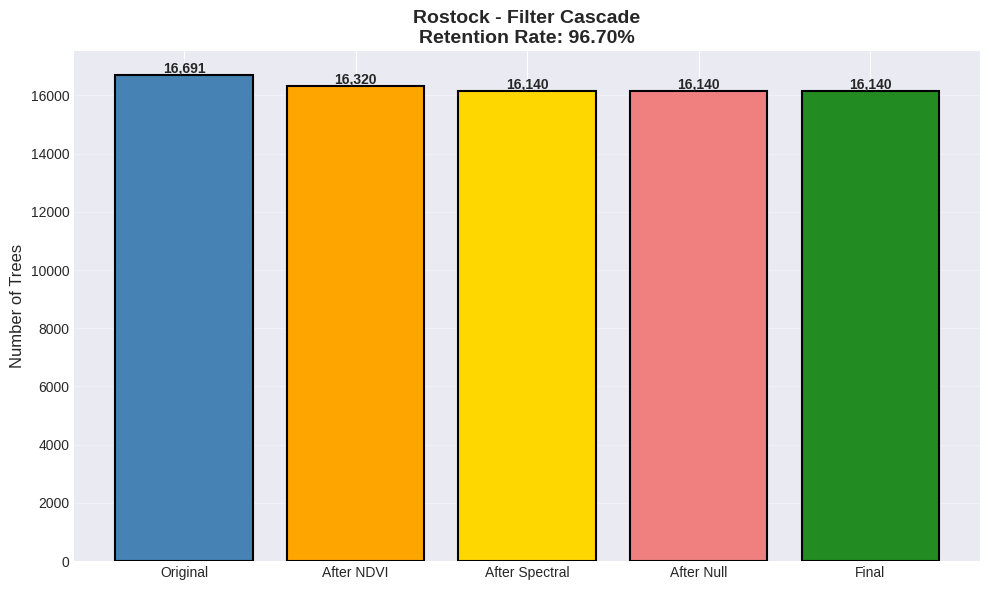


############################################################
# PROCESSING COMPLETE
############################################################


In [7]:
# Initialize results storage
all_stats = []
cleaned_gdfs = {}

# Process each city
for city in CITIES:
    try:
        # Load data
        print(f"\n{'#'*60}")
        print(f"# PROCESSING: {city}")
        print(f"{'#'*60}")

        gdf_original = load_tree_features(city)

        # Apply filters
        gdf_clean, stats = apply_qc_filters(gdf_original, city)

        # Store results
        all_stats.append(stats)
        cleaned_gdfs[city] = gdf_clean

        # Save cleaned data
        output_path = FEATURES_DIR / f"trees_with_features_clean_{city}.gpkg"
        gdf_clean.to_file(output_path, driver="GPKG")
        print(f"✓ Saved cleaned data: {output_path}")

        # Generate visualizations
        print(f"\nGenerating visualizations for {city}...")

        # NDVI distribution
        ndvi_plot_path = REPORTS_DIR / f"ndvi_distribution_{city}.png"
        plot_ndvi_distribution(gdf_original, gdf_clean, city, save_path=ndvi_plot_path)

        # Filter cascade
        cascade_plot_path = REPORTS_DIR / f"filter_cascade_{city}.png"
        plot_filter_cascade(stats, save_path=cascade_plot_path)

    except Exception as e:
        print(f"\n❌ ERROR processing {city}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'#'*60}")
print("# PROCESSING COMPLETE")
print(f"{'#'*60}")

---

## 6. Generate Summary Reports

In [8]:
# Create summary DataFrame
df_summary = pd.DataFrame(all_stats)

# Reorder columns for better readability
column_order = [
    'city', 'original_count', 'after_ndvi', 'removed_ndvi',
    'after_spectral', 'removed_spectral', 'after_zero', 'removed_zero',
    'final_count', 'total_removed', 'retention_pct'
]
df_summary = df_summary[column_order]

# Save CSV report
csv_path = REPORTS_DIR / "qc_report.csv"
df_summary.to_csv(csv_path, index=False)
print(f"✓ Saved QC report: {csv_path}")

# Display summary table
print("\n" + "="*80)
print("QUALITY CONTROL SUMMARY")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

✓ Saved QC report: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/qc_report.csv

QUALITY CONTROL SUMMARY
   city  original_count  after_ndvi  removed_ndvi  after_spectral  removed_spectral  after_zero  removed_zero  final_count  total_removed  retention_pct
 Berlin          190469      181797          8672          178283              3514      178283             0       178283          12186      93.602108
Hamburg           48519       47296          1223           46179              1117       46179             0        46179           2340      95.177147
Rostock           16691       16320           371           16140               180       16140             0        16140            551      96.698820


In [9]:
# Generate text summary report
summary_text_path = REPORTS_DIR / "qc_summary.txt"

with open(summary_text_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("PHASE 2: QUALITY CONTROL & NDVI FILTERING - SUMMARY REPORT\n")
    f.write("="*80 + "\n\n")

    f.write("Filter Thresholds:\n")
    f.write(f"  - NDVI_min:  {NDVI_MIN}\n")
    f.write(f"  - B04_max:   {B04_MAX}\n")
    f.write(f"  - B08_max:   {B08_MAX}\n\n")

    f.write("Results by City:\n")
    f.write("-"*80 + "\n\n")

    for stats in all_stats:
        city = stats['city']
        f.write(f"{city}:\n")
        f.write(f"  Original:          {stats['original_count']:>8,} trees\n")
        f.write(f"  After NDVI filter: {stats['after_ndvi']:>8,} trees ({100 * stats['after_ndvi'] / stats['original_count']:.1f}%)\n")
        f.write(f"  After Spectral:    {stats['after_spectral']:>8,} trees ({100 * stats['after_spectral'] / stats['original_count']:.1f}%)\n")
        f.write(f"  After Null filter: {stats['after_zero']:>8,} trees ({100 * stats['after_zero'] / stats['original_count']:.1f}%)\n")
        f.write(f"  Final:             {stats['final_count']:>8,} trees ({stats['retention_pct']:.1f}% retained)\n")
        f.write(f"  Total removed:     {stats['total_removed']:>8,} trees ({100 - stats['retention_pct']:.1f}%)\n")
        f.write("\n")

    f.write("="*80 + "\n")
    f.write("Overall Statistics:\n")
    f.write("="*80 + "\n")

    total_original = df_summary['original_count'].sum()
    total_final = df_summary['final_count'].sum()
    total_removed = df_summary['total_removed'].sum()
    overall_retention = 100 * total_final / total_original

    f.write(f"Total Original Trees:  {total_original:>10,}\n")
    f.write(f"Total Final Trees:     {total_final:>10,}\n")
    f.write(f"Total Removed:         {total_removed:>10,}\n")
    f.write(f"Overall Retention:     {overall_retention:>10.2f}%\n")
    f.write("\n")

    # Validation checks
    f.write("Validation Checks:\n")
    f.write("-"*80 + "\n")

    for stats in all_stats:
        city = stats['city']
        retention = stats['retention_pct']

        if retention >= 85:
            status = "✓ PASS"
        elif retention >= 70:
            status = "⚠ WARNING"
        else:
            status = "✗ FAIL"

        f.write(f"  {city}: {status} (Retention: {retention:.2f}%)\n")

print(f"✓ Saved text summary: {summary_text_path}")

# Display summary
with open(summary_text_path, 'r') as f:
    print("\n" + f.read())

✓ Saved text summary: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/qc_summary.txt

PHASE 2: QUALITY CONTROL & NDVI FILTERING - SUMMARY REPORT

Filter Thresholds:
  - NDVI_min:  0.3
  - B04_max:   5000
  - B08_max:   8000

Results by City:
--------------------------------------------------------------------------------

Berlin:
  Original:           190,469 trees
  After NDVI filter:  181,797 trees (95.4%)
  After Spectral:     178,283 trees (93.6%)
  After Null filter:  178,283 trees (93.6%)
  Final:              178,283 trees (93.6% retained)
  Total removed:       12,186 trees (6.4%)

Hamburg:
  Original:            48,519 trees
  After NDVI filter:   47,296 trees (97.5%)
  After Spectral:      46,179 trees (95.2%)
  After Null filter:   46,179 trees (95.2%)
  Final:               46,179 trees (95.2% retained)
  Total removed:        2,340 trees (4.8%)

Rostock:
  Original:            16,691 trees
  After NDVI filter:   16,320 trees (97.8%)

---

## 7. Validation & Quality Checks

In [10]:
print("\n" + "="*80)
print("VALIDATION CHECKS")
print("="*80 + "\n")

for city in CITIES:
    if city not in cleaned_gdfs:
        print(f"⚠ Warning: {city} not processed")
        continue

    gdf = cleaned_gdfs[city]
    print(f"\n{city}:")
    print("-" * 40)

    # Check 1: NDVI_max distribution
    ndvi_max = calculate_ndvi_max(gdf)
    print(f"  NDVI_max statistics:")
    print(f"    Min:    {np.min(ndvi_max):.3f}")
    print(f"    Median: {np.median(ndvi_max):.3f}")
    print(f"    Mean:   {np.mean(ndvi_max):.3f}")
    print(f"    Max:    {np.max(ndvi_max):.3f}")

    if np.min(ndvi_max) >= NDVI_MIN:
        print(f"    ✓ All trees have NDVI >= {NDVI_MIN}")
    else:
        print(f"    ✗ ERROR: Some trees have NDVI < {NDVI_MIN}")

    # Check 2: Spectral outliers
    b04_max = calculate_spectral_max(gdf, 'B04')
    b08_max = calculate_spectral_max(gdf, 'B08')

    print(f"\n  Spectral outliers:")
    print(f"    B04_max: {np.max(b04_max):.1f} (threshold: {B04_MAX})")
    print(f"    B08_max: {np.max(b08_max):.1f} (threshold: {B08_MAX})")

    if np.max(b04_max) < B04_MAX and np.max(b08_max) < B08_MAX:
        print(f"    ✓ No spectral outliers detected")
    else:
        print(f"    ✗ WARNING: Spectral outliers still present")

    # Check 3: Null pixels
    spectral_sum = calculate_spectral_sum(gdf)
    null_pixels = np.sum(spectral_sum == 0)

    print(f"\n  Null pixels:")
    print(f"    Count: {null_pixels}")

    if null_pixels == 0:
        print(f"    ✓ No null pixels detected")
    else:
        print(f"    ✗ ERROR: {null_pixels} trees with all-zero spectral values")

    # Check 4: Retention rate
    stats = [s for s in all_stats if s['city'] == city][0]
    retention = stats['retention_pct']

    print(f"\n  Retention rate: {retention:.2f}%")
    if retention >= 85:
        print(f"    ✓ PASS (≥85%)")
    elif retention >= 70:
        print(f"    ⚠ WARNING (70-85%)")
    else:
        print(f"    ✗ FAIL (<70%)")

print("\n" + "="*80)
print("VALIDATION COMPLETE")
print("="*80)


VALIDATION CHECKS


Berlin:
----------------------------------------
  NDVI_max statistics:
    Min:    0.300
    Median: 0.688
    Mean:   0.665
    Max:    0.999
    ✓ All trees have NDVI >= 0.3

  Spectral outliers:
    B04_max: 4999.0 (threshold: 5000)
    B08_max: 7934.7 (threshold: 8000)
    ✓ No spectral outliers detected

  Null pixels:
    Count: 0
    ✓ No null pixels detected

  Retention rate: 93.60%
    ✓ PASS (≥85%)

Hamburg:
----------------------------------------
  NDVI_max statistics:
    Min:    0.300
    Median: 0.744
    Mean:   0.710
    Max:    0.999
    ✓ All trees have NDVI >= 0.3

  Spectral outliers:
    B04_max: 4997.0 (threshold: 5000)
    B08_max: 7579.0 (threshold: 8000)
    ✓ No spectral outliers detected

  Null pixels:
    Count: 0
    ✓ No null pixels detected

  Retention rate: 95.18%
    ✓ PASS (≥85%)

Rostock:
----------------------------------------
  NDVI_max statistics:
    Min:    0.300
    Median: 0.735
    Mean:   0.703
    Max:    0.998
   

---

## 8. Combined Visualization (All Cities)

✓ Saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/retention_rates_comparison.png


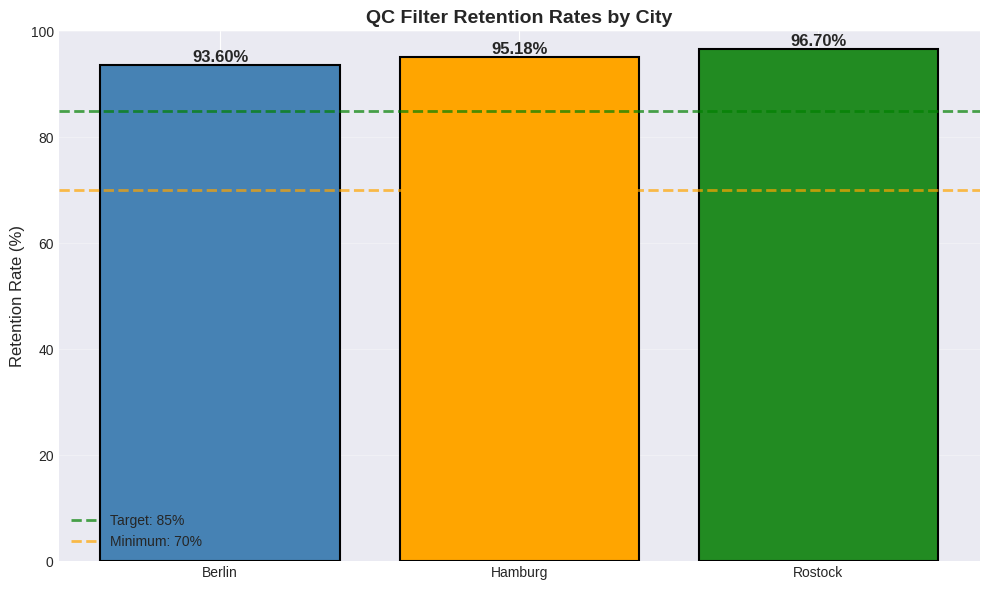

In [11]:
# Create combined retention rate comparison
fig, ax = plt.subplots(figsize=(10, 6))

cities_list = [s['city'] for s in all_stats]
retention_rates = [s['retention_pct'] for s in all_stats]

bars = ax.bar(cities_list, retention_rates,
              color=['steelblue', 'orange', 'forestgreen'],
              edgecolor='black', linewidth=1.5)

# Add value labels
for bar, rate in zip(bars, retention_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add threshold lines
ax.axhline(85, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Target: 85%')
ax.axhline(70, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Minimum: 70%')

ax.set_ylabel('Retention Rate (%)', fontsize=12)
ax.set_title('QC Filter Retention Rates by City', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.legend(fontsize=10)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()

# Save figure
combined_plot_path = REPORTS_DIR / "retention_rates_comparison.png"
plt.savefig(combined_plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {combined_plot_path}")

plt.show()

---

## 9. Summary & Next Steps

In [12]:
print("\n" + "="*80)
print("PHASE 2 COMPLETE - SUMMARY")
print("="*80 + "\n")

print("Output Files Generated:")
print("-" * 40)
print("\nCleaned Data:")
for city in CITIES:
    path = FEATURES_DIR / f"trees_with_features_clean_{city}.gpkg"
    if path.exists():
        print(f"  ✓ {path}")

print("\nReports:")
report_files = [
    "qc_report.csv",
    "qc_summary.txt",
    "retention_rates_comparison.png"
]
for filename in report_files:
    path = REPORTS_DIR / filename
    if path.exists():
        print(f"  ✓ {path}")

print("\nCity-specific Visualizations:")
for city in CITIES:
    ndvi_path = REPORTS_DIR / f"ndvi_distribution_{city}.png"
    cascade_path = REPORTS_DIR / f"filter_cascade_{city}.png"
    if ndvi_path.exists():
        print(f"  ✓ {ndvi_path}")
    if cascade_path.exists():
        print(f"  ✓ {cascade_path}")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80 + "\n")
print("1. Review validation results above")
print("2. Check retention rates (should be ≥85%)")
print("3. Inspect NDVI distribution plots")
print("4. Proceed to Phase 3: Dataset Splitting & Model Training")
print("\n")


PHASE 2 COMPLETE - SUMMARY

Output Files Generated:
----------------------------------------

Cleaned Data:
  ✓ /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/trees_with_features_clean_Berlin.gpkg
  ✓ /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/trees_with_features_clean_Hamburg.gpkg
  ✓ /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/trees_with_features_clean_Rostock.gpkg

Reports:
  ✓ /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/qc_report.csv
  ✓ /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/qc_summary.txt
  ✓ /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/retention_rates_comparison.png

City-specific Visualizations:
  ✓ /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/features/reports/ndvi_distribution_Berlin.png
  ✓ /content/drive